In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import lmfit as lm
import sys
from scipy import signal
SEED = 35010732 # from random.org
np.random.seed(SEED)
np.set_printoptions(threshold=sys.maxsize)

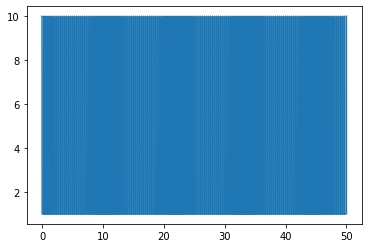

In [2]:
t = np.linspace(0,50,180000)
def mypulse(t,pulsewidth,period):
    # we have to find out whether t is in the on or off period
    whatperiod = (t/period) - int(t/period)
    if whatperiod <= pulsewidth/period:
        return 10.0
    else:
        return 1
mp = np.vectorize(mypulse)
plt.plot(t,mp(t,12/3600,1200/3600))

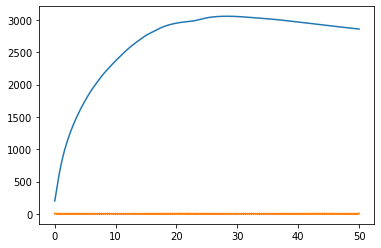

In [3]:
#ODE's
#dP0 = u*P1 - b*TetR*P0
#dP1 = -u*P1 + b*Tetr*P0
#dmRNA = -dm*mRNA + ktr*P0
#dTetR = -dpro*TetR - ki*TetR - b*P0*TetR + ka*TetRi + ktl*mRNA + u*P1 add extra term
#dTetRi = -dpro*TetRi + ki*TetR - ka*TetRi
#GFP = -dpro*GFP + ktl*mRNA

t = np.linspace(0,50,180000)
ktr = 200
ktl = 37.5
dpro = 0.06
dm = 3.35
ka = 1
ki = 3
b = 0.2
u = 20.8

def gfp(vec, t, ktr, ktl, dm, dpro, ka, ki, u, b):
    P0 = vec[0]
    P1 = vec[1]
    mRNA = vec[2]
    TetR = vec[3]
    TetRi = vec[4]
    GFP = vec[5]
    vec = [P0, P1, mRNA, TetR, TetRi, GFP]
    
    #Parameters
    ktr = 200
    ktl = 37.5
    dpro = 0.06
    dm = 3.35
    ka = 2
    ki = 2
    b = 0.2
    u = 20.8
    return np.array([u*P1 - b*TetR*P0,
                    -u*P1 + b*TetR*P0,
                    -dm*mRNA + ktr*P0,
                    #-dpro*TetR - pulse(t)*ki*TetR - b*P0*TetR + ka*TetRi + ktl*mRNA + u*P1,
                     TetR*(-dpro-mypulse(t,12/3600,1200/3600)*ki -b*P0) + ka*TetRi + ktl*mRNA + u*P1, 
                    -dpro*TetRi + ki*TetR - ka*TetRi,
                    -dpro*GFP + ktl*mRNA])
#intitial Conditions
P00 = 1
P10 = 0
mRNA0 = 10
GFP0 = 200
TetR0 = 200
TetRi0 = 20

vec0 = [P00,P10,mRNA0,TetR0,TetRi0, GFP0]

soln = odeint(gfp, vec0, t, args=(ktr,ktl,dm,dpro,ka,ki,b,u))
GFP = soln.T[5]
plt.figure()
plt.plot(t, GFP)
plt.plot(t,mp(t,12/3600,1200/3600))

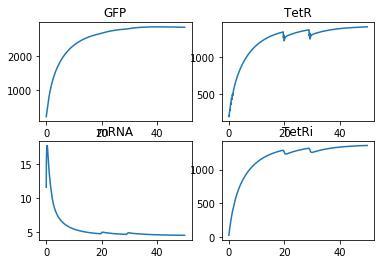

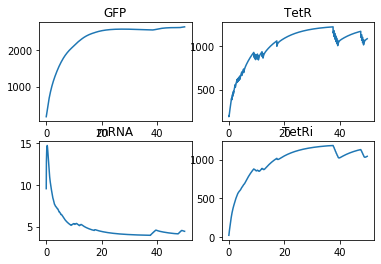

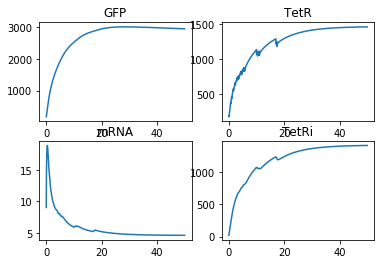

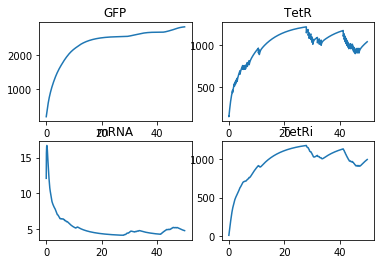

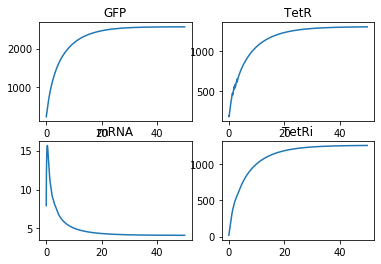

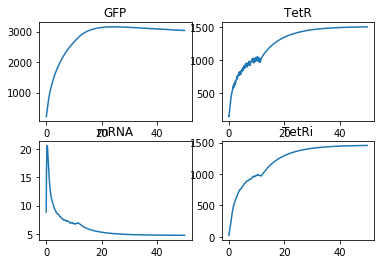

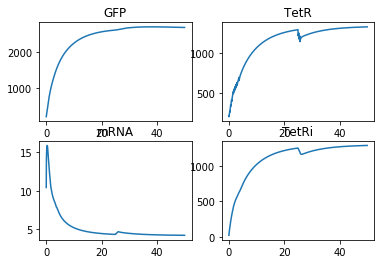

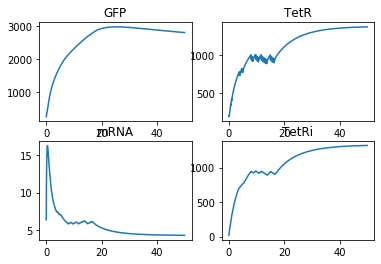

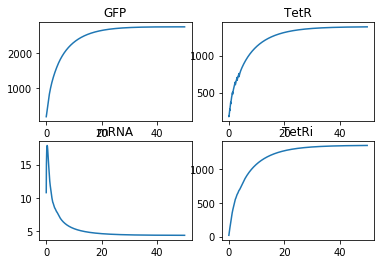

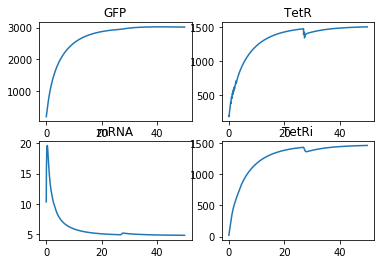

In [6]:
for i in range(10):
    #parameters
    ktr = np.random.normal(loc = 200, scale = 20)
    ktl =  np.random.normal(loc=37.5, scale = 0.005)
    dpro =  np.random.normal(loc = 0.06, scale = 0.01)
    dm =  np.random.normal(loc = 3.35, scale = 0.001)
    ka =  np.random.normal(loc= 2,scale = 0.05)
    ki =  np.random.normal(loc = 2, scale=0.05)
    b =  np.random.normal(loc = 0.2, scale = 0.0035)
    u =  np.random. normal(loc = 20.8, scale = 0.5)
    #initial conditions
    P00 = np.random.normal(loc = 1, scale =0.1)
   
    P10 = np.random.normal(loc = 0, scale = 0.1) #gamma

    mRNA0 = np.random.normal(loc = 10, scale = 2)
    
    GFP0 = np.random.normal(loc = 200, scale = 20)

    TetR0 = np.random.normal(loc = 200, scale = 20)

    TetRi0 = np.random.normal(loc = 20, scale = 2)

    vec0 = [P00,P10,mRNA0,TetR0,TetRi0, GFP0]
    x1, infodict = odeint(gfp,vec0,t, args = (ktr,ktl,dm,dpro,ka,ki,b,u), full_output = True)
    p0,p1,mRNA,TetR,TetRi,GFP = x1.T
    fig, axs = plt.subplots(2,2)
    axs[0,0].plot(t,GFP)
    axs[0,0].set_title('GFP')
    axs[0,1].plot(t,TetR)
    axs[0,1].set_title('TetR')
    axs[1,0].plot(t, mRNA)
    axs[1,0].set_title('mRNA')
    axs[1,1].plot(t,TetRi)
    axs[1,1].set_title('TetRi')
    #plt.plot(t,GFP,"-r")

Text(0, 0.5, 'integrated intensity')

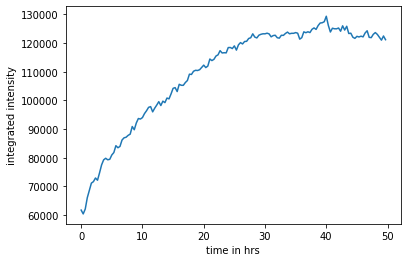

In [8]:
gfpi =pd.read_excel("12_8_20_comp_gfp_intensity.xlsx")
gfpi_data_cut = gfpi[0:150]
gfpi_data_cut = gfpi_data_cut.values.T
#gfpi_data.shape
gfpi_data_cut.shape
time = gfpi_data_cut[0].astype(np.double)
gfp_data = gfpi_data_cut[1:].astype(np.double)
for data in gfp_data[:1]:
    plt.plot(time, data)
plt.xlabel("time in hrs")
plt.ylabel("integrated intensity")

In [15]:
time.shape

(150,)

In [9]:
noise=np.sqrt(np.abs(data))

In [16]:
def DEODE(t,t0,ktr, ktl, dpro, dm, ka, ki,b,u,offset):
    f = np.zeros(np.shape(t))
    idx_after = np.array(t>t0, dtype=bool)
    dt = t[idx_after] - t0
    if dt[0]>0:
        addzero =True
        dt = np.concatenate(([0.0],dt))
    else:
        addzero =False
    result = odeint(gfp,vec0, dt, args=(ktr, ktl, dpro, dm, ka, ki,b,u))
    if addzero:
        f[idx_after] = result[:,5][1:]
    else:
        f[idx_after] = result[:,5]
    return f + offset

In [17]:
P00 = 1
P10 = 0
mRNA0 = 10
GFP0 = 200
TetR0 = 200
TetRi0 = 20

vec0 = [P00,P10,mRNA0,TetR0,TetRi0, GFP0]

DE_model = lm.Model(DEODE)
pars = DE_model.make_params()
pars['t0'].set(value = 0, vary = False)
pars['ktr'].set(value = 200, vary = True)
pars['ktl'].set(value = 37.5, vary = False)
pars['dpro'].set(value = 0.06, vary =False)
pars['dm'].set(value = 3.35, vary =False)
pars['ka'].set(value = 2, vary = False)
pars['ki'].set(value = 1, vary = False)
pars['b'].set(value = 0.2, vary = False)
pars['u'].set(value =22.8, vary = True)
out = DE_model.fit(data,pars,t=time, weights = 1/noise,nan_policy='omit')
print(out.fit_report(min_correl=0.25))

TypeError: Improper input: N=3 must not exceed M=0